In [109]:
import os, sys
sys.path.append('/workspaces/python-trend-labeller')

In [110]:
import pandas as pd

from src.viz import plot_trend_labels
from src.returns_estimation import ReturnsEstimatorWithFees
from src.optimisation import Optimiser
from src.returns_estimation.fees_config import FeesConfig
from src.trend_labelling import BinaryCTL

Let's import the data. We will use only the closing prices for our time series.

In [111]:
df_list = []
for file in sorted(os.listdir('/workspaces/python-trend-labeller/notebooks/data')):
    if file.endswith('.parquet'):
        df_list.append(pd.read_parquet(f'/workspaces/python-trend-labeller/notebooks/data/{file}'))


In [112]:
df_concat = pd.concat(df_list).sort_values(by='t')
df_concat.drop_duplicates(subset='t', keep='first', inplace=True)


# Using a labeller

We can now instantiate a binary parametrized labeller.

Uptrend periods: 7468, Downtrend periods: 4445


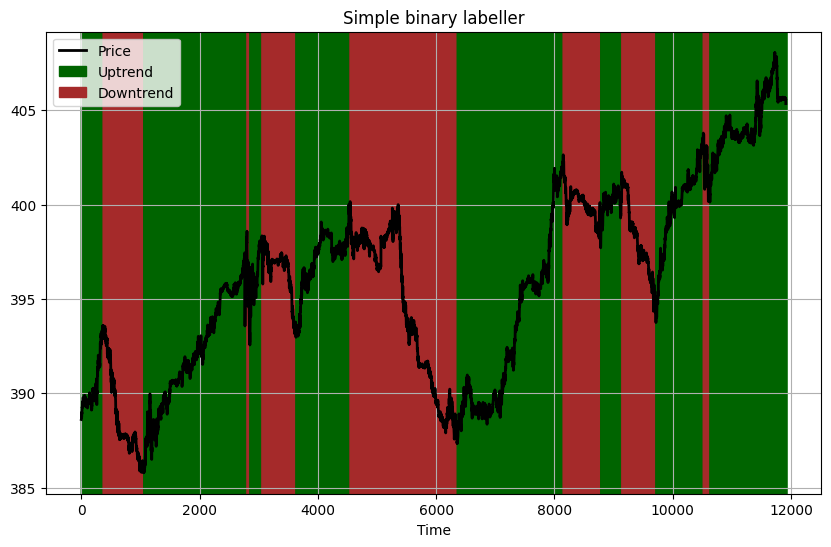

In [113]:
from collections import Counter
from itertools import chain


concatenated_closing_prices = df_concat.c.to_list()

binary_labeller = BinaryCTL(omega=0.009) # omega value from the optimization in simple_labeller_howto.py
labels = binary_labeller.get_labels(concatenated_closing_prices)
print(f"Uptrend periods: {Counter(labels)[1]}, Downtrend periods: {Counter(labels)[-1]}")
plot_trend_labels(concatenated_closing_prices, labels, title="Simple binary labeller")


# Optimise different labellers

In [114]:
from src.returns_estimation.returns_estimation import ReturnsEstimatorWithFees
from src.trend_labelling.oracle_labeller import OracleBinaryTrendLabeler

fees_config = FeesConfig(
    lp_transaction_fees=0.009, # Higher fees discourage frequent label changes
    sp_transaction_fees=0.009
)
custom_bounds = {
    "transaction_cost": (0, 0.01),
}
# Let's repeat the optimisation with the new return estimator.
opt = Optimiser(ReturnsEstimatorWithFees(fees_config), initial_points=10, nb_iter=80)
opt.optimise(OracleBinaryTrendLabeler, concatenated_closing_prices, custom_bounds, verbose=1)



|   iter    |  target   | transa... |
-------------------------------------
| 2         | 61.87     | 0.004061  |
| 5         | 63.45     | 0.006492  |


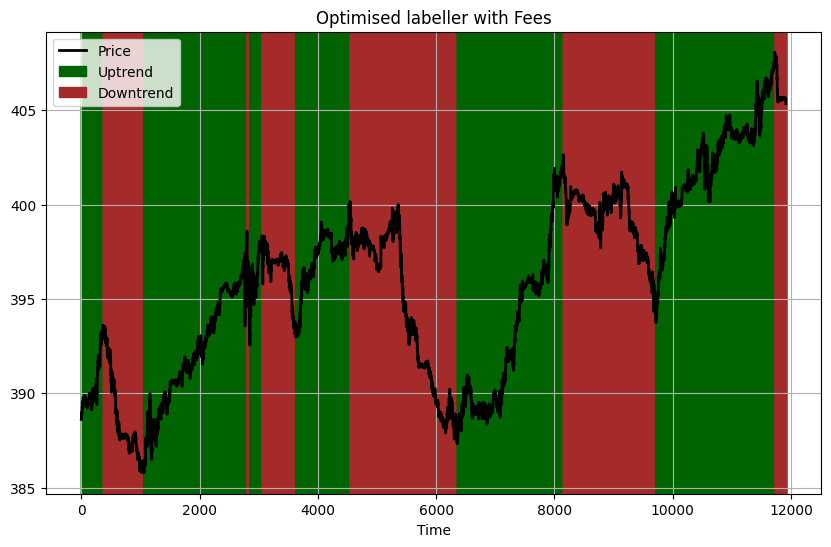

In [115]:
labeller = OracleBinaryTrendLabeler(**opt.optimiser.max['params'])
labels = labeller.get_labels(concatenated_closing_prices)
plot_trend_labels(concatenated_closing_prices, labels, title="Optimised labeller with Fees")

The FeesConfig class also allows to prioritise one position over the other. Let's for example increase the fees for the long position.


In [116]:
from src.trend_labelling.ternary_trend_labeller import TernaryCTL

custom_bounds = {
    "marginal_change_thres": (0, 0.1),
    "window_size": (1, 3000),
}
fees_config = FeesConfig(
    lp_transaction_fees=0.009, # Higher fees discourage frequent label changes
    sp_transaction_fees=0.009
)
opt = Optimiser(ReturnsEstimatorWithFees(fees_config), initial_points=10, nb_iter=80)
opt.optimise(TernaryCTL, concatenated_closing_prices, custom_bounds, verbose=1)


|   iter    |  target   | margin... | window... |
-------------------------------------------------
| 7         | 4.169     | 0.02081   | 590.3     |
| 8         | 7.203     | 0.01838   | 1.662e+03 |
| 11        | 7.502     | 0.02838   | 1.663e+03 |
| 17        | 36.1      | 0.006184  | 1.664e+03 |


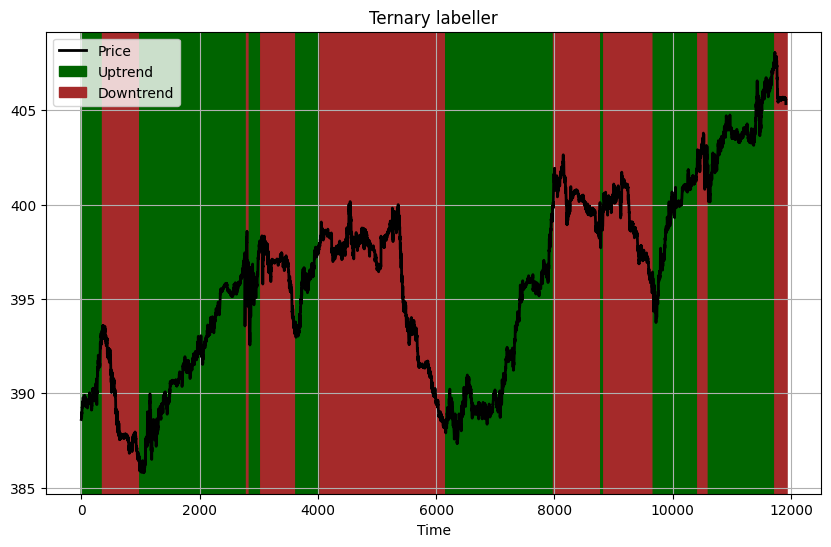

In [117]:
labeller = TernaryCTL(marginal_change_thres = opt.optimiser.max['params']["marginal_change_thres"], window_size = int(opt.optimiser.max['params']["window_size"]))
labels = labeller.get_labels(concatenated_closing_prices)
plot_trend_labels(concatenated_closing_prices, labels, title=f"Ternary labeller")

We see that the algorithm get more picky when labelling upward trends.

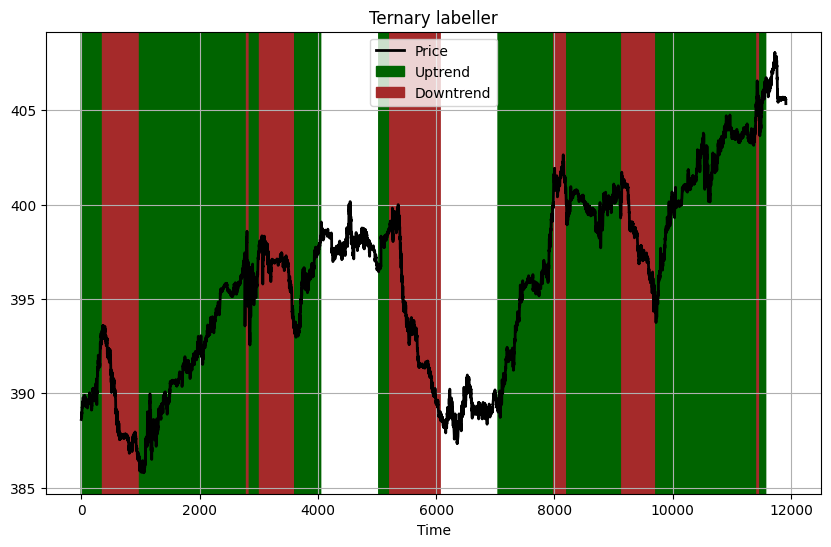

In [118]:
labeller = TernaryCTL(marginal_change_thres = 0.006, window_size = 1000)
labels = labeller.get_labels(concatenated_closing_prices)
plot_trend_labels(concatenated_closing_prices, labels, title=f"Ternary labeller")

In [207]:
from typing import List
import numpy as np
from numpy.typing import NDArray
from src.trend_labelling import BaseLabeller


class OracleTernaryTrendLabeler(BaseLabeller):
    """
    Oracle Ternary Trend Labeler class that identifies three states: downtrend (0), neutral (1), and uptrend (2).
    Transitions between downtrend and uptrend must go through the neutral state.
    """

    def __init__(self, transition_reward: float, trend_coeff: float) -> None:
        """
        Initialize the ternary trend labeler.

        Args:
            transition_reward (float): Reward coefficient for switching between trends.
            trend_coeff (float): Trend coefficient.
        """
        if not isinstance(transition_reward, float):
            raise TypeError("transition_reward must be a float.")
        self.transition_reward = transition_reward
        self.trend_coeff = trend_coeff

    def _verify_time_series(self, time_series_list: list[float]) -> None:
        """
        Verify the input time series.
        
        Args:
            time_series_list (list[float]): The price series.
        """
        if not isinstance(time_series_list, list):
            raise TypeError("time_series_list must be a list.")
        if not all(isinstance(price, (int, float)) for price in time_series_list):
            raise TypeError("All elements in time_series_list must be integers or floats.")
        if len(time_series_list) < 2:
            raise ValueError("time_series_list must contain at least two elements.")

    def _compute_transition_rewards(self, time_series_arr: NDArray) -> NDArray:
        """
        Initialize the transition reward matrix for three states.
        
        Args:
            time_series_arr (NDArray): Array of price values.
        Returns:
            NDArray: Transition reward matrix of shape (T-1, 3, 3).
        """
        T = len(time_series_arr)
        P = np.full((T - 1, 3, 3), -np.inf)  # Initialize with -inf for forbidden transitions

        for t in range(T - 1):
            price_change = time_series_arr[t + 1] - time_series_arr[t]
            switch_cost = -time_series_arr[t] * self.transition_reward

            # Rewards for staying in same state
            P[t, 0, 0] = -price_change  # Reward for staying in downtrend
            P[t, 1, 1] = abs(price_change)*self.trend_coeff  # No reward for staying neutral
            P[t, 2, 2] = price_change  # Reward for staying in uptrend

            # Rewards for allowed transitions
            P[t, 0, 1] = switch_cost  # Downtrend to neutral
            P[t, 1, 0] = switch_cost  # Neutral to downtrend
            P[t, 1, 2] = switch_cost  # Neutral to uptrend
            P[t, 2, 1] = switch_cost  # Uptrend to neutral

        return P

    def _forward_pass(self, time_series_arr: NDArray, P: NDArray) -> NDArray:
        """
        Perform the forward pass to calculate the state matrix.
        
        Args:
            time_series_arr (NDArray): Array of price values.
            P (NDArray): Transition reward matrix.
            
        Returns:
            NDArray: State matrix of cumulative returns.
        """
        T = len(time_series_arr)
        S = np.zeros((T, 3))  # Initialize state matrix for 3 states

        # Iterate over time steps in forward direction
        for t in range(1, T):
            # Maximum return for being in downtrend
            S[t, 0] = max(
                S[t-1, 0] + P[t-1, 0, 0],  # Stay in downtrend
                S[t-1, 1] + P[t-1, 1, 0]   # Switch from neutral
            )

            # Maximum return for being in neutral
            S[t, 1] = max(
                S[t-1, 0] + P[t-1, 0, 1],  # Switch from downtrend
                S[t-1, 1] + P[t-1, 1, 1],  # Stay in neutral
                S[t-1, 2] + P[t-1, 2, 1]   # Switch from uptrend
            )

            # Maximum return for being in uptrend
            S[t, 2] = max(
                S[t-1, 1] + P[t-1, 1, 2],  # Switch from neutral
                S[t-1, 2] + P[t-1, 2, 2]   # Stay in uptrend
            )

        return S

    def _backward_pass(self, S: NDArray, P: NDArray, time_series_arr: NDArray) -> NDArray:
        """
        Perform the backward pass to determine the trend labels.
        
        Args:
            S (NDArray): State matrix of cumulative returns.
            P (NDArray): Transition reward matrix.
            time_series_arr (NDArray): Array of price values.
            
        Returns:
            NDArray: Optimal trend labels (0 for downtrend, 1 for neutral, 2 for uptrend).
        """
        T = len(time_series_arr)
        labels = np.zeros(T, dtype=int)
        labels[-1] = np.argmax(S[-1])  # Start from the last state

        for t in range(T - 2, -1, -1):
            # Find state that maximizes return considering next state's label
            rewards = S[t] + P[t, :, labels[t + 1]]
            labels[t] = np.argmax(rewards)

        return labels

    def get_labels(self, time_series_list: list[float]) -> list[int]:
        """
        Run the full Oracle Ternary Trend Labeling Algorithm over a time series.
        
        Args:
            time_series_list (list[float]): The price series.
            
        Returns:
            list[int]: Optimal trend labels (0 for downtrend, 1 for neutral, 2 for uptrend).
        """
        self._verify_time_series(time_series_list)
        time_series_arr = np.array(time_series_list)

        P = self._compute_transition_rewards(time_series_arr)
        S = self._forward_pass(time_series_arr, P)
        labels = self._backward_pass(S, P, time_series_arr)

        return labels.tolist(), P, S

Counter({-1: 1311, 0: 941, 1: 748})


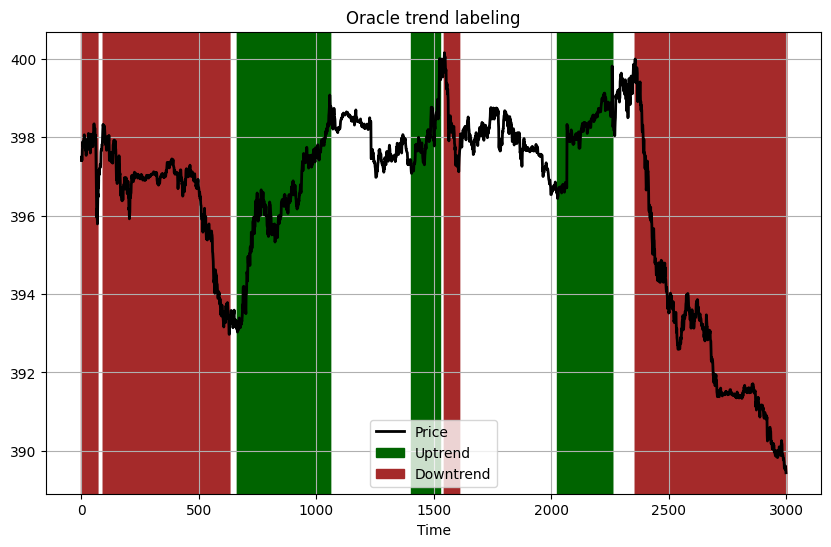

In [230]:
labels, P, S = OracleTernaryTrendLabeler(0.003, 0.03).get_labels(concatenated_closing_prices[3000:6000][::1])
# Substract 1 to each label
labels = [label - 1 for label in labels][1:]+[0]
print(Counter(labels))
plot_trend_labels(concatenated_closing_prices[3000:6000][::1], labels, title="Oracle trend labeling")

In [238]:
labels = [0,0,0,1,1,1,1]
Counter(np.array(labels)/np.array(labels).max()*2-1)

Counter({np.float64(1.0): 4, np.float64(-1.0): 3})

Counter({-1: 127, 1: 73})


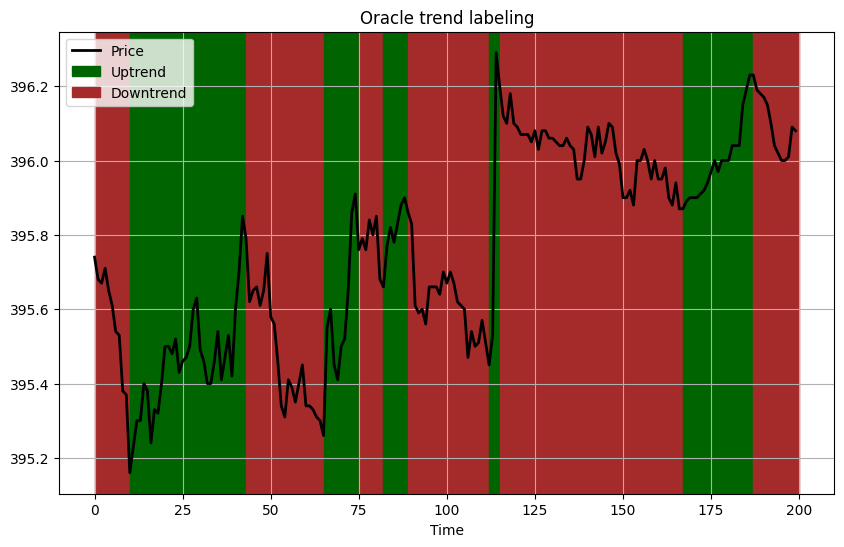

In [121]:
labels= OracleBinaryTrendLabeler(0.0003).get_labels(concatenated_closing_prices[7550:7750][::-1])
# Substract 1 to each label
print(Counter(labels))
plot_trend_labels(concatenated_closing_prices[7550:7750][::-1], labels, title="Oracle trend labeling")

In [233]:
np.array(labels)

array([-1, -1, -1, ..., -1, -1,  0])

In [123]:
for i in np.linspace(1, 10, 20):
    labels = OracleTernaryTrendLabeler(0.0004, i).get_labels(concatenated_closing_prices[::-1])
    # Count the number of intervals of contiguous labels with the same value
    nb_distinct_groups = sum(1 for i in range(len(labels)) if labels[i] != labels[i-1])
    print(round(i,4), nb_distinct_groups, sum(label==1 for label in labels))



ValueError: operands could not be broadcast together with shapes (11913,3) (11913,) 